
# ON MOUSE DYNAMICS AS METRIC FOR USER CLICK BEHAVIOUR ON YOUTUBE




by [George Ofege]


###  Abstract
In this paper, we consider the use of mouse dynamics as a metric for modelling and predicting user’s next click activity. This paper will address the Use of Sequential Models in order to predict mouse tracjectories and guess where or what hyperlink the web user is likely to click next from their movements.

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
#import tensorflow as tf
import numpy as np
import tensorflow as tf
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

c:\users\pheon\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


We need to import several things from Keras.

In [2]:
# from tf.keras.models import Sequential  # This does not work!
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras.optimizers import Adagrad
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

This was developed using Python 3.6 (Anaconda) and package versions:

In [3]:
tf.__version__

'1.7.0'

In [4]:
tf.keras.__version__

'2.1.4-tf'

In [5]:
pd.__version__


'0.22.0'

Loading the Datasets to be used, workspace on mouse dynamics

In [6]:
%%time
dataset = 'E:/pheon/Documents/DataSets/workspacedynamics.csv'
df = pd.read_csv('E:/pheon/Documents/DataSets/workspacedynamics_set2.csv')

Wall time: 51.9 ms


These are the top rows of the data-set.

In [88]:
df.head(7)

,xcoord,ycoord,direction
0,70,1,6
1,54,2,6
2,47,3,6
3,39,3,7
4,34,3,7
5,33,3,7
6,32,3,7


In [8]:
clickevent = df["click"] == 1

In [79]:
clickevents_array = np.array(df[clickevent].index) ## returns the index of a click event
yevent = df["xcoord"] == 70          ##
y_array = np.array(df[yevent].index)

y_array


array([    0,   983,  1143,  3785,  3884,  4677, 10360, 12030],
      dtype=int64)

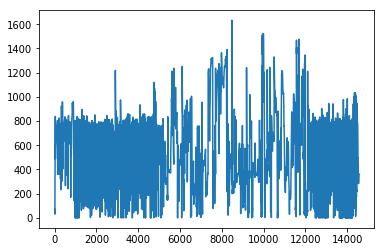

In [10]:
df['xcoord'].plot()

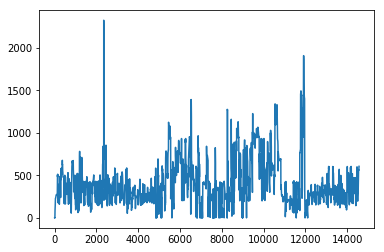

In [11]:
df['ycoord'].plot()

Before removing these two signals, there are 20 input-signals in the data-set.

In [12]:
df.values.shape

(14567, 7)

Then we remove the two signals that have missing data.

In [13]:
df.drop(('timestamp'), axis=1, inplace=True)
df.drop(('speed'), axis=1, inplace=True)
df.drop(('click'), axis=1, inplace=True)
df.drop(('element'), axis=1, inplace=True)

Now there are only 18 input-signals in the data.

In [14]:
df.values.shape

(14567, 3)

We can verify that these two data-columns have indeed been removed.

In [15]:
df.head(1)

,xcoord,ycoord,direction
0,70,1,6


In [16]:
df.isnull().sum()

xcoord       0
ycoord       0
direction    0
dtype: int64

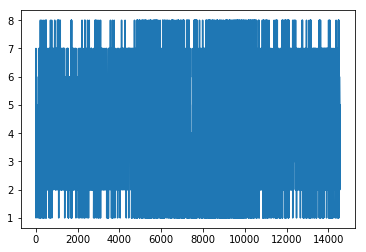

In [17]:
df['direction'].plot()

### Target Data for Prediction

We will try and predict The Next Few Coordinates


EXPERIMENTAL SETUP
 We designed a custom Mouse event tracker to monitor specific features on user data. The features monitored were:

Mouse coordinates: This is to acquire user’s position on the screen
Speed: Distance travelled in pixels per second
Direction: Inferred from the changing coordinates
Click and Div element clicked on.

The custom program was built and run on youtube website, acquire data while user’s watched videos. The mouse software listened for mouse events and when the use starts moving, would log events data to the data. 
It is worth noting, although the custom recorder was set to log mouse events to a backend database (phpmyadmin) every 100 millisecond, there are other factors which come into play here. 
-	The mouse refresh rate is only so fast, able to log coordinates at a much slower pace than user movements.
-	The calculations made would take just about (or under) a millisecond to complete, (calculations for speed)
-	This then needs to be transferred to the backend database and begin processing the next event, this can lead to data being lost as there can be very frequent lapses in time. More detail can be seen by how this affects our results.

The custom collector listen on user’s computer for four hours at a time, over 4 individual sessions. This
After collecting the mouse Data, we now have to prepare this for our model


### Click Events and Elements Clicked
We will try and predict these signals. xcoord, ycoord. In other iterations, we included click and element events as part of our predictions, but this was inneficient for the model, the values for these events do not change over time and are usually more likely to occur when the user has moved to certain coordinates. If our model can follow the trail of these coordinates, it would provide a beter avenue and structure for determining which event is likely to be clicked given a particular sequence of events

In [18]:
target_names = ['xcoord', 'ycoord']

In [19]:

shift_steps = 1 * 7

In [20]:
df_targets = df[target_names].shift(-7)

In [86]:
df.shape

(14567, 3)

The following is the first 5 rows of the time-shifted data-frame. This should be identical to the last 5 rows shown above from the original data, except for the time-stamp.

In [89]:
df_targets.head(5)

,xcoord,ycoord
0,31.0,3.0
1,31.0,3.0
2,31.0,1.0
3,31.0,1.0
4,31.0,0.0


The time-shifted data-frame has the same length as the original data-frame, but the last observations are `NaN` (not a number) because the data has been shifted backwards so we are trying to shift data that does not exist in the original data-frame.

In [90]:
df_targets[14550:]

,xcoord,ycoord
14550,355.0,565.0
14551,358.0,574.0
14552,359.0,580.0
14553,360.0,589.0
14554,360.0,594.0
14555,360.0,597.0
14556,360.0,600.0
14557,360.0,601.0
14558,361.0,604.0
14559,361.0,606.0


### NumPy Arrays

We now convert the Pandas data-frames to NumPy arrays that can be input to the neural network. We also remove the last part of the numpy arrays, because the target-data has `NaN` for the shifted period, and we only want to have valid data and we need the same array-shapes for the input- and output-data.

These are the input-signals:

In [91]:
x_data = df.values[0:-7]

In [99]:
x_data[7000:4].shape

(0, 3)

In [92]:
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (14560, 3)


These are the output-signals (or target-signals):

In [26]:
y_data = df_targets.values[:-7]

In [27]:
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (14560, 2)


This is the number of observations (aka. data-points or samples) in the data-set:

In [28]:
num_data = len(x_data)
num_data

14560

This is the fraction of the data-set that will be used for the training-set:

In [29]:
train_split = 0.9

This is the number of observations in the training-set:

In [30]:
num_train = int(train_split * num_data)
num_train

13104

This is the number of observations in the test-set:

In [31]:
num_test = num_data - num_train
num_test

1456

These are the input-signals for the training- and test-sets:

In [32]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

14560

These are the output-signals for the training- and test-sets:

In [33]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

14560

This is the number of input-signals:

In [34]:
num_x_signals = x_data.shape[1]
num_x_signals

3

This is the number of output-signals:

In [35]:
num_y_signals = y_data.shape[1]
num_y_signals

2

### Scaled Data

The data-set contains a wide range of values:

In [36]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: 0
Max: 2323


The neural network works best on values roughly between -1 and 1, so we need to scale the data before it is being input to the neural network. We can use `scikit-learn` for this.

We first create a scaler-object for the input-signals.

In [37]:
x_scaler = MinMaxScaler()

We then detect the range of values from the training-data and scale the training-data.

In [38]:
x_train_scaled = x_scaler.fit_transform(x_train)

c:\users\pheon\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Apart from a small rounding-error, the data has been scaled to be between 0 and 1.

In [39]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0


We use the same scaler-object for the input-signals in the test-set.

In [40]:
x_test_scaled = x_scaler.transform(x_test)

In [41]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [42]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(13104, 3)
(13104, 2)


In [84]:
y_train_scaled[0]

array([0.01898347, 0.00129143])

In [80]:
def clickindex():
    iter = np.random.randint(len(clickevents_array) - 3)  ##returns index an item in clickevents_array
    return clickevents_array[iter]     ## returns item in clickevents_array

clickindex()

1902

In [45]:
idc = clickindex()

In [77]:
x_train_scaled[idc - 20:idc]


array([[0.34047765, 0.11149376, 0.28571429],
       [0.34170239, 0.11106328, 0.14285714],
       [0.34231476, 0.1106328 , 0.14285714],
       [0.3496632 , 0.10891089, 0.14285714],
       [0.36619718, 0.10891089, 0.28571429],
       [0.39314146, 0.11235471, 0.28571429],
       [0.42437232, 0.11665949, 0.28571429],
       [0.46785058, 0.12268618, 0.28571429],
       [0.5345989 , 0.12957383, 0.28571429],
       [0.5407226 , 0.1300043 , 0.28571429],
       [0.55419473, 0.13086526, 0.28571429],
       [0.56460502, 0.13258717, 0.28571429],
       [0.56399265, 0.13430908, 0.57142857],
       [0.55725658, 0.13732243, 0.71428571],
       [0.54623393, 0.13904434, 0.71428571],
       [0.51439069, 0.13689195, 0.85714286],
       [0.50949173, 0.13560052, 0.85714286],
       [0.49724434, 0.13473956, 0.85714286],
       [0.49357012, 0.13430908, 0.85714286],
       [0.49234538, 0.13430908, 0.85714286]])

### Creating the sequences in a batch
Creating a batch of multiple sequences which will be used to train the model. Instead of using random sequences from the dataset, the batch generator acquires the last few events leading up to a click event. The lengh is defined by the 'sequence lengh'

In [47]:
def batch_generator(batch_size, sequence_length):
   
    while True:
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        for i in range(batch_size):
            # this gets a random index from the list if indices generated earlier.. clickevents_array
            #clickevents_array[np.random.randint(len(clickevents_array) - 3)]
            idx = np.random.choice(clickevents_array)
    
            # Get array sequences beginning at index, idx
            try:
                x_batch[i] = x_train_scaled[idx - sequence_length:idx]
                y_batch[i] = y_train_scaled[idx - sequence_length:idx]
            except:
                continue;
        
        yield (x_batch, y_batch)

We used variable batch_sizes, from 128 to 256 to 512

In [48]:
batch_size = 128

The 'sequence_lenght' used would be  varying sizes, but relatively short sequences, We tried sequence lenghts of sizes 8 - 30. This is to depict the mousemovements, Some mouse movements are extremely fast, and takes users just under 1 second to click on a div element. actions leading up to click will only usually cover a select few events or timesteps.

In [49]:
sequence_length = 20
sequence_length

20

We then create the batch-generator.

In [50]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)



In [51]:
x_batch, y_batch = next(generator)


This gives us a random batch of 128/256/512 sequences, each sequence having 8-30 observations, and each observation having 3 input-signals and 2 output-signals.

In [52]:
print(x_batch.shape)
print(y_batch.shape)

(128, 20, 3)
(128, 20, 2)


We can plot one of the 20 input-signals as an example.

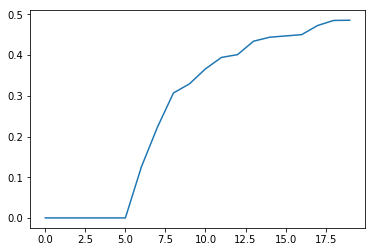

In [53]:
batch = 0   
signal = 0  
seq = x_batch[batch, :, signal]
plt.plot(seq)

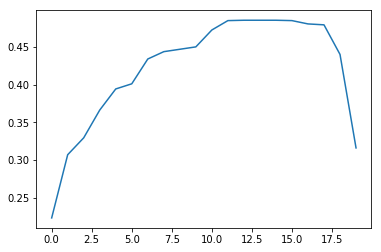

In [54]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

In [55]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [56]:
model = Sequential()

In [57]:
model.add(GRU(units=256,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

In [58]:
model.add(Dense(num_y_signals, activation='sigmoid'))

In [59]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

### Loss Function

We will use Mean Squared Error (MSE) as the loss-function that will be minimized.

At the beginning of a sequence, the model has only seen  a few time-steps, so its generated output may be very inaccurate. The models output may be affected if a the loss value is applied on earlier timesteps. We can then set a varying lenght of timesteps, during which the models accuracy will not be used in the loss, This paper used varying steps of '10 - 50'

In [60]:
warmup_steps = 5

In [61]:
def loss_mse_warmup(y_true, y_pred):

    
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

### Compile Model

Making use of SGD Optimizer

In [62]:
optimizer = SGD(lr=1e-1)

We then compile the Keras model so it is ready for training.

In [63]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [64]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 256)         199680    
_________________________________________________________________
dense_1 (Dense)              (None, None, 2)           514       
Total params: 200,194
Trainable params: 200,194
Non-trainable params: 0
_________________________________________________________________


In [65]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [66]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=4, verbose=1)

In [67]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [68]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.2,
                                       min_lr=1e-7,
                                       patience=0,
                                       verbose=1)

In [69]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

## Train the Recurrent Neural Network

We can now train the neural network.

We now train the recurrent Neural Network. Our model takes the sequences and begins training over 100 epochs

In [70]:
%%time
model.fit_generator(generator=generator,
                    epochs=30,
                    steps_per_epoch=600,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/30
599/600 [============================>.] - ETA: 0s - loss: 0.0253
Epoch 00001: val_loss improved from inf to 0.02992, saving model to 23_checkpoint.keras
600/600 [==============================] - 53s 89ms/step - loss: 0.0253 - val_loss: 0.0299
Epoch 2/30
599/600 [============================>.] - ETA: 0s - loss: 0.0154
Epoch 00002: val_loss did not improve

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.020000000298023225.
600/600 [==============================] - 54s 91ms/step - loss: 0.0154 - val_loss: 0.0361
Epoch 3/30
599/600 [============================>.] - ETA: 0s - loss: 0.0140
Epoch 00003: val_loss did not improve

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.003999999910593033.
600/600 [==============================] - 49s 81ms/step - loss: 0.0140 - val_loss: 0.0369
Epoch 4/30
599/600 [============================>.] - ETA: 0s - loss: 0.0138
Epoch 00004: val_loss did not improve

Epoch 00004: ReduceLROnPlateau reducing learning rate to

## Evaluating Model Performance

We can now evaluate the model's performance. We will just use one long time-series for the test-set, so we just expand the array-dimensionality to create a batch with that one sequence.

In [71]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 232ms/step


In [72]:
print("loss (test-set):", result)

loss (test-set): 0.03697672858834267


 ### Plot predictions

In [73]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.1)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

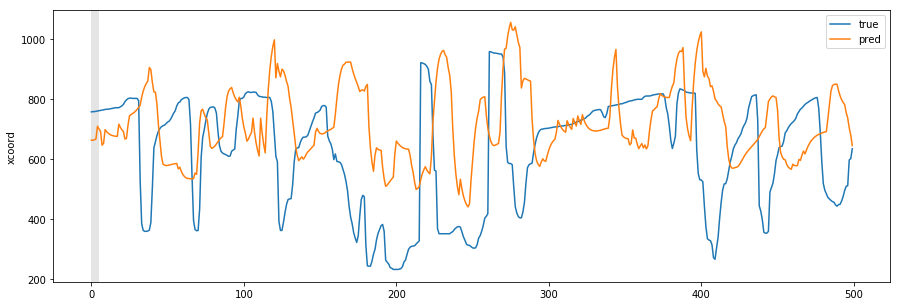

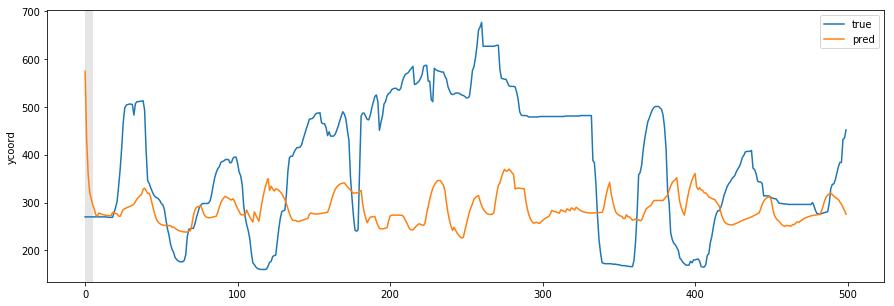

In [74]:
plot_comparison(start_idx=100, length=500, train=True)


#### Discussions and Conclusions about model can be found in Research Paper